# Recurrent Neural Network To Predict Stock Price

Using multiple attributes of the dataset to make the prediction.

In [92]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler

In [94]:
dataset = pd.read_csv('petr4_training.csv')
dataset = dataset.dropna()
dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0
...,...,...,...,...,...,...,...
1240,2017-12-25,15.750000,15.750000,15.750000,15.750000,15.718563,0.0
1241,2017-12-26,15.750000,15.990000,15.690000,15.970000,15.938125,22173100.0
1242,2017-12-27,15.990000,16.139999,15.980000,16.049999,16.017963,23552200.0
1243,2017-12-28,16.100000,16.129999,16.000000,16.100000,16.067865,19011500.0


In [95]:
dataset_train = dataset.iloc[:, 1:7].values
dataset_train

array([[1.9990000e+01, 2.0209999e+01, 1.9690001e+01, 1.9690001e+01,
        1.8086271e+01, 3.0182600e+07],
       [1.9809999e+01, 2.0400000e+01, 1.9700001e+01, 2.0400000e+01,
        1.8738441e+01, 3.0552600e+07],
       [2.0330000e+01, 2.0620001e+01, 2.0170000e+01, 2.0430000e+01,
        1.8766001e+01, 3.6141000e+07],
       ...,
       [1.5990000e+01, 1.6139999e+01, 1.5980000e+01, 1.6049999e+01,
        1.6017963e+01, 2.3552200e+07],
       [1.6100000e+01, 1.6129999e+01, 1.6000000e+01, 1.6100000e+01,
        1.6067865e+01, 1.9011500e+07],
       [1.6100000e+01, 1.6100000e+01, 1.6100000e+01, 1.6100000e+01,
        1.6067865e+01, 0.0000000e+00]])

In [96]:
normalizer = MinMaxScaler(feature_range= (0, 1))
dataset_train = normalizer.fit_transform(dataset_train)

dataset_train

array([[0.76501938, 0.77266112, 0.79682707, 0.76080559, 0.6838135 ,
        0.04318274],
       [0.7562984 , 0.78187106, 0.79733884, 0.79567784, 0.71590949,
        0.0437121 ],
       [0.78149225, 0.79253519, 0.82139202, 0.79715132, 0.71726583,
        0.05170752],
       ...,
       [0.57122093, 0.57537562, 0.60696008, 0.58202356, 0.58202349,
        0.03369652],
       [0.57655039, 0.57489089, 0.60798362, 0.5844794 , 0.58447937,
        0.02720006],
       [0.57655039, 0.57343674, 0.61310133, 0.5844794 , 0.58447937,
        0.        ]])

In [97]:
# criar as variaveis x e y baseado nos 90 preços anteriores
x, y = [], []

# using the last 90 prices to predict the next
for i in range(90, 1242): 
    x.append(dataset_train[i-90:i, 0:6])
    y.append(dataset_train[i, 0])

x, y = np.array(x), np.array(y)

In [98]:
x[0], x.shape, y[0], y.shape

(array([[0.76501938, 0.77266112, 0.79682707, 0.76080559, 0.6838135 ,
         0.04318274],
        [0.7562984 , 0.78187106, 0.79733884, 0.79567784, 0.71590949,
         0.0437121 ],
        [0.78149225, 0.79253519, 0.82139202, 0.79715132, 0.71726583,
         0.05170752],
        [0.78875969, 0.7949588 , 0.81013311, 0.77996075, 0.70144373,
         0.04015963],
        [0.77083338, 0.77363063, 0.78505624, 0.75147351, 0.67522435,
         0.0416214 ],
        [0.74806197, 0.75618037, 0.78505624, 0.76031438, 0.68336137,
         0.03485382],
        [0.75436047, 0.76490543, 0.78915051, 0.76768177, 0.69014234,
         0.02507502],
        [0.75823643, 0.76442079, 0.79733884, 0.77013751, 0.6924025 ,
         0.0260728 ],
        [0.76598837, 0.77411537, 0.79682707, 0.76227897, 0.68516964,
         0.0404927 ],
        [0.76598837, 0.77411537, 0.79682707, 0.76719061, 0.68969016,
         0.0423977 ],
        [0.76017437, 0.75714973, 0.79222108, 0.76817293, 0.69059437,
         0.02401858],

In [99]:
model = Sequential()

model.add(LSTM(units= 100, return_sequences=True, input_shape= (x.shape[1], 6)))
model.add(Dropout(rate= 0.3))

model.add(LSTM(units= 50, return_sequences=True))
model.add(Dropout(rate= 0.3))

model.add(LSTM(units= 50, return_sequences=True))
model.add(Dropout(rate= 0.3))

model.add(LSTM(units= 50))
model.add(Dropout(rate= 0.3))

model.add(Dense(units= 1, activation= 'linear'))

c:\Users\Pedro\Documents\codigos\Deep-Learning\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [100]:
model.compile(optimizer= tf.keras.optimizers.Adam(), loss= 'mean_squared_error', metrics= ['mean_absolute_error'])

In [101]:
# defining callbacks
es = EarlyStopping(monitor= 'loss', patience= 10, verbose= True, min_delta= 1e-10)
rlr = ReduceLROnPlateau(monitor= 'loss', patience= 5, verbose= 1, factor= 0.2)
mcp = ModelCheckpoint(filepath= 'weights.keras', monitor= 'loss', save_best_only= True, verbose= 1)

In [102]:
model.fit(
    x,
    y,
    epochs= 100,
    batch_size= 32,
    callbacks= [es, rlr, mcp]
)

Epoch 1/100


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0519 - mean_absolute_error: 0.1679
Epoch 1: loss improved from inf to 0.02479, saving model to weights.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0511 - mean_absolute_error: 0.1664 - learning_rate: 0.0010
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0083 - mean_absolute_error: 0.0689
Epoch 2: loss improved from 0.02479 to 0.00805, saving model to weights.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0083 - mean_absolute_error: 0.0689 - learning_rate: 0.0010
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0075 - mean_absolute_error: 0.0658
Epoch 3: loss improved from 0.00805 to 0.00795, saving model to weights.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0075 - mean_absolute_error: 0.0659 - learning_rate: 0.0010
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0075 - mean_absolute_error: 0.0669
Epoch 4: loss improved from 0.00795 to 0.00694, saving model to wei

In [103]:
dataset_test = pd.read_csv('petr4_test.csv')
dataset_test

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,16.190001,16.549999,16.190001,16.549999,16.516966,33461800
1,2018-01-03,16.490000,16.719999,16.370001,16.700001,16.666668,55940900
2,2018-01-04,16.780001,16.959999,16.620001,16.730000,16.696608,37064900
3,2018-01-05,16.700001,16.860001,16.570000,16.830000,16.796408,26958200
4,2018-01-08,16.740000,17.030001,16.709999,17.030001,16.996010,28400000
5,2018-01-09,17.030001,17.160000,16.959999,17.030001,16.996010,35070900
6,2018-01-10,16.920000,17.049999,16.770000,16.799999,16.766466,28547700
7,2018-01-11,16.879999,17.299999,16.840000,17.250000,17.215569,37921500
8,2018-01-12,17.040001,17.410000,17.020000,17.299999,17.265469,45912100
9,2018-01-15,17.320000,17.440001,17.150000,17.350000,17.315371,28945400


In [104]:
y_test = dataset_test.iloc[:, 1:2].values
y_test

array([[16.190001],
       [16.49    ],
       [16.780001],
       [16.700001],
       [16.74    ],
       [17.030001],
       [16.92    ],
       [16.879999],
       [17.040001],
       [17.32    ],
       [17.35    ],
       [17.92    ],
       [18.35    ],
       [18.309999],
       [18.26    ],
       [18.4     ],
       [18.42    ],
       [19.34    ],
       [19.620001],
       [19.67    ],
       [19.77    ],
       [19.74    ]])

In [105]:
dataset_completed = pd.concat((dataset, dataset_test))
dataset_completed

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0
...,...,...,...,...,...,...,...
17,2018-01-25,19.340000,19.340000,19.340000,19.340000,19.301397,0.0
18,2018-01-26,19.620001,19.980000,19.100000,19.930000,19.890221,81989500.0
19,2018-01-29,19.670000,20.049999,19.570000,19.850000,19.810381,55726200.0
20,2018-01-30,19.770000,19.770000,19.360001,19.490000,19.451097,46203000.0


In [106]:
dataset_completed = dataset_completed.drop('Date', axis= 1)

In [107]:
inputs = dataset_completed[len(dataset_completed) - len(dataset_test) - 90:].values
inputs.shape

(112, 6)

In [108]:
inputs = normalizer.transform(inputs)

In [109]:
x_test = []

for i in range(90, 112):
    x_test.append(inputs[i-90:i, 0:6])
    
x_test = np.array(x_test)
x_test.shape

(22, 90, 6)

In [110]:
predictions = model.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


In [111]:
normalizer_prediction = MinMaxScaler(feature_range= (0, 1))
normalizer_prediction.fit_transform(dataset.iloc[:, 1:2].values)

predictions = normalizer_prediction.inverse_transform(predictions)

In [112]:
predictions

array([[16.099188],
       [16.229784],
       [16.343098],
       [16.452255],
       [16.560308],
       [16.669828],
       [16.78189 ],
       [16.879951],
       [16.962038],
       [17.03288 ],
       [17.100897],
       [17.180065],
       [17.305603],
       [17.487396],
       [17.705324],
       [17.927776],
       [18.113873],
       [18.277636],
       [18.451311],
       [18.66211 ],
       [18.906788],
       [19.13954 ]], dtype=float32)

In [113]:
y_test

array([[16.190001],
       [16.49    ],
       [16.780001],
       [16.700001],
       [16.74    ],
       [17.030001],
       [16.92    ],
       [16.879999],
       [17.040001],
       [17.32    ],
       [17.35    ],
       [17.92    ],
       [18.35    ],
       [18.309999],
       [18.26    ],
       [18.4     ],
       [18.42    ],
       [19.34    ],
       [19.620001],
       [19.67    ],
       [19.77    ],
       [19.74    ]])

In [114]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, predictions)

0.49865741878440173

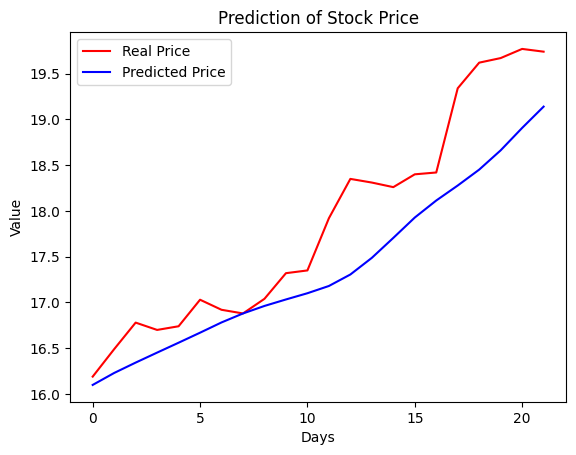

In [115]:
plt.plot(y_test, color= "red", label= "Real Price")
plt.plot(predictions, color= "blue", label= "Predicted Price")
plt.title("Prediction of Stock Price")
plt.xlabel("Days")
plt.ylabel("Value")
plt.legend()